In [18]:
import os
import cv2
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from tqdm import tqdm
import numpy as np

def load_images_and_labels(image_folder, label_folder):
    images = []
    labels = []
    filenames = []
    for filename in os.listdir(image_folder):
        img_path = os.path.join(image_folder, filename)
        label_path = os.path.join(label_folder, filename.replace('jpg', 'txt'))
        img = cv2.imread(img_path)
        if img is not None:
            images.append(img)
            if os.path.exists(label_path):
                with open(label_path, 'r') as file:
                    label_data = file.readlines()
                    labels.append([line.strip().split() for line in label_data])
            else:
                labels.append([])
            filenames.append(filename)
    return images, labels, filenames

def apply_augmentations(images, labels):
    augmented_images = []
    augmented_labels = []

    transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.RandomBrightnessContrast(p=0.4),
        A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.3),
        # A.Crop(p=0.3)
    ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

    for img, label_list in zip(images, labels):
        bboxes = [[float(label[1]), float(label[2]), float(label[3]), float(label[4])] for label in label_list]
        class_labels = [int(label[0]) for label in label_list]
        augmented = transform(image=img, bboxes=bboxes, class_labels=class_labels)
        augmented_images.append(augmented['image'])
        augmented_labels.append([list(bbox) + [label] for bbox, label in zip(augmented['bboxes'], augmented['class_labels'])])
    return augmented_images, augmented_labels

def save_images_and_labels(images, labels, filenames, image_folder, label_folder):
    for img, label, filename in zip(images, labels, filenames):
        cv2.imwrite(os.path.join(image_folder, filename), img)
        label_filename = filename.replace('jpg', 'txt')
        with open(os.path.join(label_folder, label_filename), 'w') as file:
            for line in label:
                file.write(f"{int(line[4])} {line[0]:.6f} {line[1]:.6f} {line[2]:.6f} {line[3]:.6f}\n")

# Training Data
source_image_folder = '/Users/declanbracken/Development/Khthon/Ethiopian Monestary Detection.v1-original_42_noaug.yolov8/train/images'
source_label_folder = '/Users/declanbracken/Development/Khthon/Ethiopian Monestary Detection.v1-original_42_noaug.yolov8/train/labels'
images_tr, labels_tr, filenames_tr = load_images_and_labels(source_image_folder, source_label_folder)
augmented_images_tr, augmented_labels_tr = apply_augmentations(images_tr, labels_tr)

In [48]:
# Validation Data
source_image_folder_val = '/Users/declanbracken/Development/Khthon/Ethiopian Monestary Detection.v1-original_42_noaug.yolov8/valid/images'
source_label_folder_val= '/Users/declanbracken/Development/Khthon/Ethiopian Monestary Detection.v1-original_42_noaug.yolov8/valid/labels'
images_val, labels_val, filenames_val = load_images_and_labels(source_image_folder_val, source_label_folder_val)
augmented_images_val, augmented_labels_val = apply_augmentations(images_val, labels_val)

In [51]:
# Test Data
source_image_folder_test = '/Users/declanbracken/Development/Khthon/Ethiopian Monestary Detection.v1-original_42_noaug.yolov8/test/images'
source_label_folder_test = '/Users/declanbracken/Development/Khthon/Ethiopian Monestary Detection.v1-original_42_noaug.yolov8/test/labels'
images_test, labels_test, filenames_test = load_images_and_labels(source_image_folder_test, source_label_folder_test)
augmented_images_test, augmented_labels_test = apply_augmentations(images_test, labels_test)

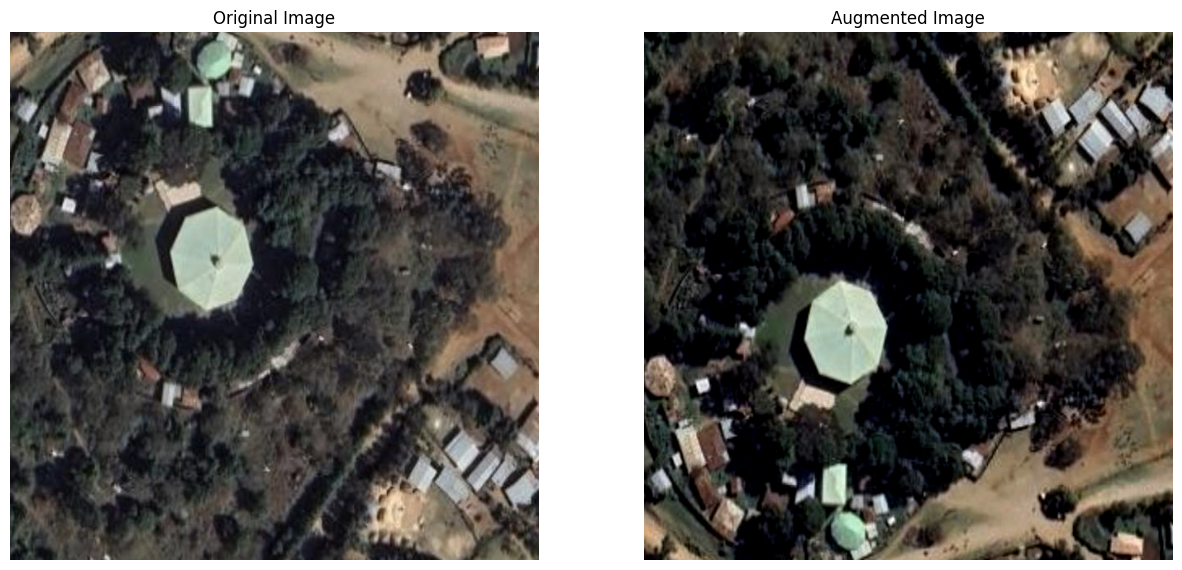

In [15]:
import cv2
import matplotlib.pyplot as plt

def visualize_bbox(img, bbox, color=(255, 0, 0), thickness=2):
    """A utility function to visualize bounding boxes on the image."""
    x_min, y_min, x_max, y_max = bbox
    cv2.rectangle(img, (int(x_min), int(y_min)), (int(x_max), int(y_max)), color, thickness)

def visualize(image, bboxes, title=""):
    """Utility to visualize an image and its bounding boxes."""
    img = image.copy()
    # for bbox in bboxes:
    #     x_center, y_center, width, height = bbox
    #     x_min = (x_center - width / 2) * img.shape[1]
    #     y_min = (y_center - height / 2) * img.shape[0]
    #     x_max = (x_center + width / 2) * img.shape[1]
    #     y_max = (y_center + height / 2) * img.shape[0]
    #     visualize_bbox(img, (x_min, y_min, x_max, y_max))
    
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')

def plot_comparison(original_image, augmented_image, original_labels, augmented_labels):
    """Plots the original and augmented images side by side for comparison."""
    fig, ax = plt.subplots(1, 2, figsize=(15, 7))
    plt.subplot(1, 2, 1)
    visualize(original_image, original_labels, "Original Image")
    plt.subplot(1, 2, 2)
    visualize(augmented_image, augmented_labels, "Augmented Image")
    plt.show()

# Example of using the plot_comparison function
# Assume 'images', 'augmented_images', 'labels', and 'augmented_labels' are already loaded or processed
img_idx = 3
# Plot for the first image and its augmented version
plot_comparison(images_tr[img_idx], augmented_images_tr[img_idx], labels_tr[img_idx], augmented_labels_tr[img_idx])

In [ ]:
img_idx = 10
# Plot for the first image and its augmented version
plot_comparison(images_val[img_idx], augmented_images_val[img_idx], labels_val[img_idx], augmented_labels_val[img_idx])

In [24]:
destination_image_folder = '/Users/declanbracken/Development/Khthon/Ethiopian Monestary Detection Labeled/train/images'
destination_label_folder = '/Users/declanbracken/Development/Khthon/Ethiopian Monestary Detection Labeled/train/labels'
filenames_1 = np.arange(len(augmented_labels_tr))
filenames_1_1 = [str(filename) + '_1.jpg' for filename in filenames_1]
save_images_and_labels(augmented_images_tr, augmented_labels_tr, filenames_1_1, destination_image_folder, destination_label_folder)

In [ ]:
img_idx = 10
# Plot for the first image and its augmented version
plot_comparison(images_test[img_idx], augmented_images_test[img_idx], labels_test[img_idx], augmented_labels_test[img_idx])